In [3]:
import tensorflow as tf
import os 
import numpy as np
import numpy.random as rng
from tensorflow.examples.tutorials.mnist import input_data
from rbm.examples import bas_data 
from rbm.helper import batch 
from rbm.model import rbm 
import matplotlib.pyplot as plt
import time 

mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
mnist_train = mnist.train

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
# Create session.
sess = tf.InteractiveSession()

# Initialize RBM Model for MNIST reconstruction
rbm_model= rbm.RBM(n_visible = 784, n_hidden = 64, lr = tf.constant(0.003,tf.float32), epochs = 10000)

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None,rbm_model.n_visible], name="visible_layer")
size = tf.cast(tf.shape(v)[0], tf.float32)

#W = tf.Variable(tf.random_normal([rbm_model.n_visible, rbm_model.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (rbm_model.n_visible + rbm_model.n_hidden))), name="weights")
# Initialize weights and biases for the RBM
with tf.name_scope('Weights'):
    W = tf.Variable(tf.random_normal([rbm_model.n_visible, rbm_model.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (rbm_model.n_visible + rbm_model.n_hidden))), name="weights")
    tf.summary.histogram('weights',W)
    
vb = tf.Variable(tf.zeros([1,rbm_model.n_visible]),tf.float32, name="visible_bias")
hb = tf.Variable(tf.zeros([1,rbm_model.n_hidden]),tf.float32, name="hidden_bias")
#error = tf.Variable(tf.zeros([rbm_model.n_visible,rbm_model.n_hidden]),tf.float32, name="error")
#err = np.zeros(rbm_model.epochs)

# Similarity between reconstructed/sampled visible layer and input during training. 
# Summary for Tensorboard visualization 
with tf.name_scope("Accuracy"): 
    accuracy = tf.Variable(0.0,name="accuracy")
    tf.summary.scalar('accuracy',accuracy)
    
#with tf.name_scope("Free_energy"):
 #   energy = tf.Variable(0.0,name="free_energy")
     #  tf.summary.scalar('free_energy',energy)

# K-step Contrastive Divergence using Gibbs sampling
# Positive divergence v_0^T * p(h_0|v_0)
with tf.name_scope('Hidden_probabilities'):
    pos_hid_prob = rbm.get_gaussian_probabilities('hidden',W,v,hb)
with tf.name_scope('Positive_Divergence'):
    pos_divergence = tf.matmul(tf.transpose(v),pos_hid_prob)

pos_hid_states = rbm.sample(pos_hid_prob)
neg_vis_prob = rbm.get_gaussian_probabilities('visible', W, pos_hid_states, vb)

# Negative part v_sampled^T * p(h_sample_k+1|v_sample_k)
with tf.name_scope('Negative_hidden_probabilities'):
    neg_hid_prob = rbm.get_gaussian_probabilities('hidden', W, neg_vis_prob, hb)
with tf.name_scope('Negative_Divergence'):
    neg_divergence = tf.matmul(tf.transpose(neg_vis_prob),neg_hid_prob)
    
    
# Accuracy on reconstructing visible layer and free energy
a = tf.reduce_mean(tf.squared_difference(v,neg_vis_prob))
acc_update = [accuracy.assign(a)]
#energy  =  rbm.free_energy(v = v, weights=W,hbias=hb,vbias=vb) 
#accuracy_update = [accuracy.assign_add(reconstruction_accuracy)]
    
# Update rules for weights and biases
# Summaries of gradient for Tensorboard visualization
with tf.name_scope('Weight_gradient'):
    delta_w = tf.multiply(rbm_model.lr/size, tf.subtract(pos_divergence,neg_divergence))
    weight_gradient_scalar = tf.summary.scalar('weight_increment',tf.reduce_mean(delta_w))
with tf.name_scope('Visible_bias_gradient'):
    delta_vb = tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(v,neg_vis_prob), 0, keep_dims=True))
with tf.name_scope('Hidden_bias_gradient'):
    delta_hb= tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(pos_hid_prob,neg_hid_prob), 0, keep_dims=True))

update = [W.assign_add(delta_w), vb.assign_add(delta_vb), hb.assign_add(delta_hb)] 
# Debug mode
# Weight increment changes as seen by plotting delta_w for the entire dataset
#error_sum = [error.assign_add(delta_w)]
#total_err = tf.reduce_mean(error)
#reinit = error.assign(tf.zeros([rbm_model.n_visible,rbm_model.n_hidden]))

# Merge summaries for Tensorboard
summary = tf.summary.merge_all()
path_test = os.getcwd()  + '/RBM_logs/MNIST'
test_writer = tf.summary.FileWriter(path_test,sess.graph)

sess.run(tf.global_variables_initializer())


In [8]:
start_time = time.time()
##### Start of training ######
##### -----------------#######
for epoch in range(rbm_model.epochs):
    #if epoch % 30 == 0: 
        #sess.run(reinit)
    if epoch % 500 == 0:
        feed={v: mnist.test.images}
        result = sess.run([acc_update,summary],feed_dict=feed)
        acc = result[0]
        test_writer.add_summary(result[1],epoch)
        print("Accuracy at step %s: %s" % (epoch, acc))
        #err[epoch] = sess.run(total_err)
        #print("Absolute gradient estimate of log-likelihood on epoch %s is %s" %(epoch,np.abs(err[epoch])))
    else: 
        batchXs, batchYs = mnist.train.next_batch(10)
        feed={v: batchXs}
        result = sess.run([update], feed_dict = feed)
        # Print log-likelihood to visualize how it decreases 
    
##### --------------- ######        
##### End of Training ######

# Plot
print("Elapsed time for training Bernoulli RBM with CD-1 and %s epochs: %s "%(rbm_model.epochs,time.time()-start_time))
#rbm.plot_weight_update(x=np.arange(0,rbm_model.epochs,1),y=np.abs(err))

Accuracy at step 0: [0.40131581]
Accuracy at step 500: [0.045911692]
Accuracy at step 1000: [0.024344124]
Accuracy at step 1500: [0.017720725]
Accuracy at step 2000: [0.014792512]
Accuracy at step 2500: [0.01316728]
Accuracy at step 3000: [0.012045268]
Accuracy at step 3500: [0.011089141]
Accuracy at step 4000: [0.010336568]
Accuracy at step 4500: [0.0095482664]
Accuracy at step 5000: [0.0088593168]
Accuracy at step 5500: [0.0082810959]
Accuracy at step 6000: [0.0078383731]
Accuracy at step 6500: [0.0074729421]
Accuracy at step 7000: [0.0072103976]
Accuracy at step 7500: [0.0069695837]
Accuracy at step 8000: [0.0067995866]
Accuracy at step 8500: [0.0066793128]
Accuracy at step 9000: [0.0065385164]
Accuracy at step 9500: [0.0064274147]
Elapsed time for training Bernoulli RBM with CD-1 and 10000 epochs: 22.966170072555542 


## Reconstruct some digits using Gibbs sampling

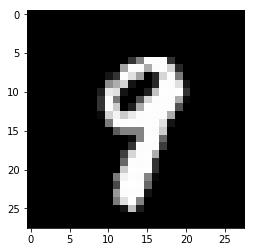

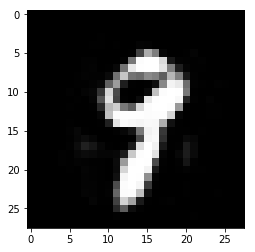

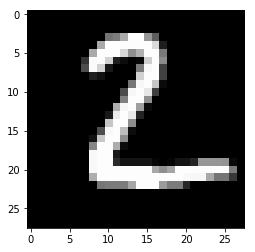

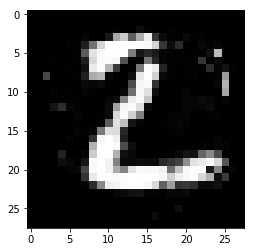

In [9]:
##### Testing ##### 
# Testing the RBM for one sample step after learning the weights        
first_image = 1
test_image = mnist_train.images[first_image]
test_image2 = mnist.test.images[first_image]
def show_digit(x):
    plt.imshow(x.reshape((28,28)),cmap = plt.cm.gray)
    plt.show()

sample = rbm.gibbs_gaussian(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
sample_test = rbm.gibbs_gaussian(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image2.reshape(1,-1).astype(np.float32)})    
show_digit(test_image)
show_digit(sample)

show_digit(test_image2)
show_digit(sample_test)
tf.reset_default_graph()

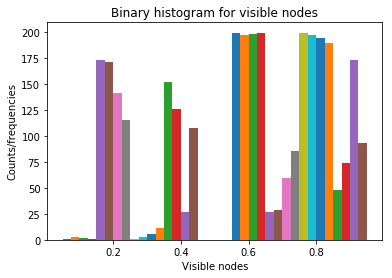

In [3]:
# plt.imshow(res[1:100],interpolation="None",cmap=plt.cm.gray)
plt.hist(res,bins=2)
plt.title('Binary histogram for visible nodes')
plt.xlabel('Visible nodes')
plt.ylabel('Counts/frequencies')
plt.show()